In this sheet I will apply Convolutional Neural Networks for stock prediction of company X stock price. I will divide data from last N years into chunks. Every day contains one value (PREDICTION_LABEL). Predicted output has two classes: whether stock will go up or down or stay constant \$\{PREDICTION_AFTER_DAYS\} days after last input.

In [1]:
OBSERVATION_TIME = 200
PREDICTION_AFTER_DAYS = 20
EPOCHS = 500
TEST_SIZE = 0.1
RANDOM_SPLIT = False
NORMALIZED_CHUNKS = True
PREDICTION_LABEL = 'Open'

**IMPORTANT NOTE** Selecting test/valiations chunks randomly from the whole set of observation chunks seems to be a big mistake. It causes situation where network actually seen chunks from the future, therefore the more overfitted network, the better results will be. Network should be trained incrementally - with data from time x to x+1 and validated with data from x+1 to x+2. Then learned with data from x to x+2 and validated with data from x+3 to x+3 and so on..

Parameter RANDOM_SPLIT is responsible for that feature. If True, then data set is split randomly into train/test set (network knows sets from the future). When False, then split is chronological - network works like in real world.

In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv('./data/AAPL.csv')
df.reindex(index=df.index[::-1])

df.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2005-05-18,5.064286,5.365714,4.998571,5.120000,4.432371,159180700
1,2005-05-19,5.111429,5.382857,5.111429,5.364286,4.643848,198290400
2,2005-05-20,5.321429,5.378572,5.312857,5.364286,4.643848,113162700
3,2005-05-23,5.407143,5.700000,5.407143,5.680000,4.917161,260643600
4,2005-05-24,5.635714,5.712857,5.575714,5.671429,4.909742,148365000


In [3]:
# PREPROCESSING

def percentage_to_label(percentage_value):
    return 0 if percentage_value < 0 else 1

def investor_observes_stocks_for(x_days=60, then_buy_stocks=True, and_sells_them=True, after_y_days=10, dataframe=df):
    assert then_buy_stocks
    assert and_sells_them
    observe_buy_sell_process_length = x_days + after_y_days
    
    observed_chunks = []
    observation_results = []
    
    for first_day_of_observation in range(len(dataframe) - observe_buy_sell_process_length):
        buyout_day = first_day_of_observation + x_days
        sell_day = buyout_day + after_y_days
        
        observed_chunk = dataframe[first_day_of_observation:buyout_day].reset_index()
        observation_result = dataframe.iloc[sell_day]
        
        closing_price_on_buyout_day = dataframe.iloc[buyout_day]['Close']
        opening_price_on_sell_day = dataframe.iloc[sell_day]['Open']
        
        relative_price_change_as_percentage = (opening_price_on_sell_day - closing_price_on_buyout_day) / closing_price_on_buyout_day * 100
        
        observed_chunks += [observed_chunk]
        observation_results += [percentage_to_label(relative_price_change_as_percentage)]
    
    return observed_chunks, observation_results

observed_chunks, observation_results = investor_observes_stocks_for(x_days=OBSERVATION_TIME, then_buy_stocks=True, and_sells_them=True, after_y_days=PREDICTION_AFTER_DAYS)

In [4]:
observed_chunks[0]

,index,Date,Open,High,Low,Close,Adj Close,Volume
0,0,2005-05-18,5.064286,5.365714,4.998571,5.120000,4.432371,159180700
1,1,2005-05-19,5.111429,5.382857,5.111429,5.364286,4.643848,198290400
2,2,2005-05-20,5.321429,5.378572,5.312857,5.364286,4.643848,113162700
3,3,2005-05-23,5.407143,5.700000,5.407143,5.680000,4.917161,260643600
4,4,2005-05-24,5.635714,5.712857,5.575714,5.671429,4.909742,148365000
...,...,...,...,...,...,...,...,...
195,195,2006-02-27,10.284286,10.302857,10.092857,10.141429,8.779409,197810200
196,196,2006-02-28,10.225715,10.342857,9.728572,9.784286,8.470230,316745100
197,197,2006-03-01,9.834286,9.927143,9.717143,9.871428,8.545672,190954400
198,198,2006-03-02,9.855714,9.998571,9.810000,9.944285,8.608742,156318400


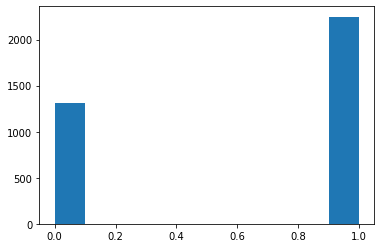

1    2248
0    1307
dtype: int64

In [5]:
import matplotlib.pyplot as plt

plt.hist(observation_results)
plt.show()

pd.Series(observation_results).value_counts()

In [6]:
# NORMALIZATION

def normalize_chunk(chunk):
    df = chunk.copy()
    for label_to_normalize in ['Open', 'High', 'Low', 'Close', 'Adj Close']:
        np_arr = df[label_to_normalize].to_numpy()
        df[label_to_normalize] = pd.Series((np.array(np_arr) - np.mean(np_arr)) / np.std(np_arr))
    return df

def normalize_chunks(chunks):
    return list(map(lambda x: normalize_chunk(x), chunks))

observed_chunks = normalize_chunks(observed_chunks) if NORMALIZED_CHUNKS else observed_chunks

In [7]:
# TRAIN TEST SPLIT

from sklearn.model_selection import train_test_split

X = np.array(list(map(lambda df: df[[PREDICTION_LABEL]].to_numpy(), observed_chunks)))
Y = np.array(observation_results).astype('float32')

def chronological_split(X_data, Y_data, test_size=0.25):
    training_test_split_index = int((1 - test_size) * len(X_data))
    X_train = X_data[:training_test_split_index]
    Y_train = Y_data[:training_test_split_index]
    X_test = X_data[training_test_split_index:]
    Y_test = Y_data[training_test_split_index:]
    return X_train, X_test, Y_train, Y_test
    
def random_split(X_data, Y_data, test_size=0.25):
    return train_test_split(X_data, Y_data, test_size=test_size, random_state=42)

X_train, X_test, Y_train, Y_test = random_split(X, Y, TEST_SIZE) if RANDOM_SPLIT else chronological_split(X, Y, TEST_SIZE)

X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((3199, 200, 1), (3199,), (356, 200, 1), (356,))

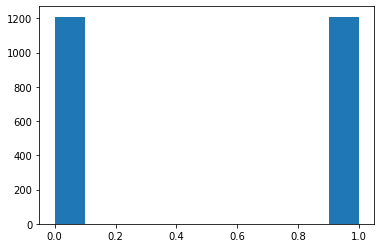

1.0    1209
0.0    1209
dtype: int64

In [8]:
# UNDERSAMPLING TRAINING SET

import random

def undersample_and_shuffle(X, Y):
    count_class_1, count_class_0 = pd.Series(Y).value_counts()

    lower_count = count_class_0 if count_class_0 < count_class_1 else count_class_1
    lower_class = 0 if count_class_0 < count_class_1 else 1
    
    diff = abs(count_class_0 - count_class_1)
    
    vec0 = random.sample([(x, y) for x, y in zip(X, Y) if y == 0], lower_count)
    vec1 = random.sample([(x, y) for x, y in zip(X, Y) if y == 1], lower_count)

    
    vec = vec0 + vec1
    random.shuffle(vec)
    return np.array(list(map(lambda x: x[0], vec))), np.array(list(map(lambda x: x[1], vec)))
    
X_train_balanced, Y_train_balanced = undersample_and_shuffle(X_train, Y_train)

plt.hist(Y_train_balanced)
plt.show()

pd.Series(Y_train_balanced).value_counts()

In [9]:
from keras import models
from keras.models import Sequential
from keras.layers import Convolution1D, MaxPooling1D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import *
from keras.layers.core import Dense, Dropout, Activation, Flatten

model = Sequential()
model.add(Convolution1D(input_shape = (OBSERVATION_TIME, 1), filters=16, kernel_size=5, padding='same'))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dropout(0.5))

model.add(Convolution1D(filters=8, kernel_size=5, padding='same'))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(64))
model.add(BatchNormalization())
model.add(LeakyReLU())

model.add(Dense(1, activation='sigmoid'))

model.summary()

Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 200, 16)           96        
_________________________________________________________________
batch_normalization_1 (Batch (None, 200, 16)           64        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 200, 16)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 200, 16)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 200, 8)            648       
_________________________________________________________________
batch_normalization_2 (Batch (None, 200, 8)            32        
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 200, 8)           

In [10]:
from keras.optimizers import Nadam
import keras

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]


model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=METRICS)

In [11]:

history = model.fit(x=X_train_balanced, 
                    y=Y_train_balanced, 
                    batch_size=128, 
                    epochs=EPOCHS, 
                    validation_data=(X_test, Y_test),
                    shuffle=True)

model.save("model-binary.h5")
model.save_weights('model-binary-weights.h5')

Train on 2418 samples, validate on 356 samples
Epoch 1/500
2418/2418 [==============================] - 1s 488us/step - loss: 0.7673 - tp: 488.0000 - fp: 437.0000 - tn: 772.0000 - fn: 721.0000 - accuracy: 0.5211 - precision: 0.5276 - recall: 0.4036 - auc: 0.5412 - val_loss: 0.7281 - val_tp: 117.0000 - val_fp: 37.0000 - val_tn: 61.0000 - val_fn: 141.0000 - val_accuracy: 0.5000 - val_precision: 0.7597 - val_recall: 0.4535 - val_auc: 0.5224
Epoch 2/500
2418/2418 [==============================] - 0s 175us/step - loss: 0.7101 - tp: 601.0000 - fp: 474.0000 - tn: 735.0000 - fn: 608.0000 - accuracy: 0.5525 - precision: 0.5591 - recall: 0.4971 - auc: 0.5827 - val_loss: 0.6525 - val_tp: 165.0000 - val_fp: 64.0000 - val_tn: 34.0000 - val_fn: 93.0000 - val_accuracy: 0.5590 - val_precision: 0.7205 - val_recall: 0.6395 - val_auc: 0.6239
Epoch 3/500
2418/2418 [==============================] - 0s 156us/step - loss: 0.6880 - tp: 680.0000 - fp: 497.0000 - tn: 712.0000 - fn: 529.0000 - accuracy: 0.5757

Epoch 22/500
2418/2418 [==============================] - 0s 172us/step - loss: 0.5711 - tp: 878.0000 - fp: 377.0000 - tn: 832.0000 - fn: 331.0000 - accuracy: 0.7072 - precision: 0.6996 - recall: 0.7262 - auc: 0.7779 - val_loss: 0.7549 - val_tp: 101.0000 - val_fp: 17.0000 - val_tn: 81.0000 - val_fn: 157.0000 - val_accuracy: 0.5112 - val_precision: 0.8559 - val_recall: 0.3915 - val_auc: 0.6681
Epoch 23/500
2418/2418 [==============================] - 0s 155us/step - loss: 0.5712 - tp: 863.0000 - fp: 364.0000 - tn: 845.0000 - fn: 346.0000 - accuracy: 0.7064 - precision: 0.7033 - recall: 0.7138 - auc: 0.7740 - val_loss: 0.7649 - val_tp: 95.0000 - val_fp: 5.0000 - val_tn: 93.0000 - val_fn: 163.0000 - val_accuracy: 0.5281 - val_precision: 0.9500 - val_recall: 0.3682 - val_auc: 0.6835
Epoch 24/500
2418/2418 [==============================] - 0s 172us/step - loss: 0.5724 - tp: 846.0000 - fp: 350.0000 - tn: 859.0000 - fn: 363.0000 - accuracy: 0.7051 - precision: 0.7074 - recall: 0.6998 - auc: 

Epoch 43/500
2418/2418 [==============================] - 0s 157us/step - loss: 0.4747 - tp: 939.0000 - fp: 272.0000 - tn: 937.0000 - fn: 270.0000 - accuracy: 0.7758 - precision: 0.7754 - recall: 0.7767 - auc: 0.8592 - val_loss: 0.8721 - val_tp: 109.0000 - val_fp: 23.0000 - val_tn: 75.0000 - val_fn: 149.0000 - val_accuracy: 0.5169 - val_precision: 0.8258 - val_recall: 0.4225 - val_auc: 0.6462
Epoch 44/500
2418/2418 [==============================] - 0s 156us/step - loss: 0.4814 - tp: 938.0000 - fp: 279.0000 - tn: 930.0000 - fn: 271.0000 - accuracy: 0.7725 - precision: 0.7707 - recall: 0.7758 - auc: 0.8534 - val_loss: 0.8841 - val_tp: 104.0000 - val_fp: 15.0000 - val_tn: 83.0000 - val_fn: 154.0000 - val_accuracy: 0.5253 - val_precision: 0.8739 - val_recall: 0.4031 - val_auc: 0.6628
Epoch 45/500
2418/2418 [==============================] - 0s 156us/step - loss: 0.4862 - tp: 931.0000 - fp: 296.0000 - tn: 913.0000 - fn: 278.0000 - accuracy: 0.7626 - precision: 0.7588 - recall: 0.7701 - auc

Epoch 64/500
2418/2418 [==============================] - 0s 153us/step - loss: 0.3968 - tp: 1013.0000 - fp: 212.0000 - tn: 997.0000 - fn: 196.0000 - accuracy: 0.8313 - precision: 0.8269 - recall: 0.8379 - auc: 0.9085 - val_loss: 0.9229 - val_tp: 99.0000 - val_fp: 18.0000 - val_tn: 80.0000 - val_fn: 159.0000 - val_accuracy: 0.5028 - val_precision: 0.8462 - val_recall: 0.3837 - val_auc: 0.6217
Epoch 65/500
2418/2418 [==============================] - 0s 153us/step - loss: 0.4012 - tp: 996.0000 - fp: 205.0000 - tn: 1004.0000 - fn: 213.0000 - accuracy: 0.8271 - precision: 0.8293 - recall: 0.8238 - auc: 0.9060 - val_loss: 0.9506 - val_tp: 105.0000 - val_fp: 22.0000 - val_tn: 76.0000 - val_fn: 153.0000 - val_accuracy: 0.5084 - val_precision: 0.8268 - val_recall: 0.4070 - val_auc: 0.6056
Epoch 66/500
2418/2418 [==============================] - 0s 152us/step - loss: 0.4040 - tp: 1003.0000 - fp: 213.0000 - tn: 996.0000 - fn: 206.0000 - accuracy: 0.8267 - precision: 0.8248 - recall: 0.8296 - a

Epoch 85/500
2418/2418 [==============================] - 0s 156us/step - loss: 0.3489 - tp: 1028.0000 - fp: 191.0000 - tn: 1018.0000 - fn: 181.0000 - accuracy: 0.8462 - precision: 0.8433 - recall: 0.8503 - auc: 0.9302 - val_loss: 0.8907 - val_tp: 99.0000 - val_fp: 16.0000 - val_tn: 82.0000 - val_fn: 159.0000 - val_accuracy: 0.5084 - val_precision: 0.8609 - val_recall: 0.3837 - val_auc: 0.6903
Epoch 86/500
2418/2418 [==============================] - 0s 151us/step - loss: 0.3389 - tp: 1038.0000 - fp: 161.0000 - tn: 1048.0000 - fn: 171.0000 - accuracy: 0.8627 - precision: 0.8657 - recall: 0.8586 - auc: 0.9368 - val_loss: 0.8791 - val_tp: 102.0000 - val_fp: 18.0000 - val_tn: 80.0000 - val_fn: 156.0000 - val_accuracy: 0.5112 - val_precision: 0.8500 - val_recall: 0.3953 - val_auc: 0.6808
Epoch 87/500
2418/2418 [==============================] - 0s 152us/step - loss: 0.3507 - tp: 1036.0000 - fp: 182.0000 - tn: 1027.0000 - fn: 173.0000 - accuracy: 0.8532 - precision: 0.8506 - recall: 0.8569 

Epoch 106/500
2418/2418 [==============================] - 0s 156us/step - loss: 0.3098 - tp: 1049.0000 - fp: 154.0000 - tn: 1055.0000 - fn: 160.0000 - accuracy: 0.8701 - precision: 0.8720 - recall: 0.8677 - auc: 0.9456 - val_loss: 0.9888 - val_tp: 98.0000 - val_fp: 16.0000 - val_tn: 82.0000 - val_fn: 160.0000 - val_accuracy: 0.5056 - val_precision: 0.8596 - val_recall: 0.3798 - val_auc: 0.6416
Epoch 107/500
2418/2418 [==============================] - 0s 153us/step - loss: 0.3015 - tp: 1068.0000 - fp: 139.0000 - tn: 1070.0000 - fn: 141.0000 - accuracy: 0.8842 - precision: 0.8848 - recall: 0.8834 - auc: 0.9501 - val_loss: 0.9873 - val_tp: 95.0000 - val_fp: 16.0000 - val_tn: 82.0000 - val_fn: 163.0000 - val_accuracy: 0.4972 - val_precision: 0.8559 - val_recall: 0.3682 - val_auc: 0.7017
Epoch 108/500
2418/2418 [==============================] - 0s 154us/step - loss: 0.3074 - tp: 1046.0000 - fp: 138.0000 - tn: 1071.0000 - fn: 163.0000 - accuracy: 0.8755 - precision: 0.8834 - recall: 0.865

Epoch 127/500
2418/2418 [==============================] - 0s 160us/step - loss: 0.2667 - tp: 1088.0000 - fp: 123.0000 - tn: 1086.0000 - fn: 121.0000 - accuracy: 0.8991 - precision: 0.8984 - recall: 0.8999 - auc: 0.9603 - val_loss: 0.9427 - val_tp: 124.0000 - val_fp: 34.0000 - val_tn: 64.0000 - val_fn: 134.0000 - val_accuracy: 0.5281 - val_precision: 0.7848 - val_recall: 0.4806 - val_auc: 0.6286
Epoch 128/500
2418/2418 [==============================] - 0s 154us/step - loss: 0.2661 - tp: 1071.0000 - fp: 117.0000 - tn: 1092.0000 - fn: 138.0000 - accuracy: 0.8945 - precision: 0.9015 - recall: 0.8859 - auc: 0.9616 - val_loss: 0.9068 - val_tp: 110.0000 - val_fp: 23.0000 - val_tn: 75.0000 - val_fn: 148.0000 - val_accuracy: 0.5197 - val_precision: 0.8271 - val_recall: 0.4264 - val_auc: 0.6748
Epoch 129/500
2418/2418 [==============================] - 0s 154us/step - loss: 0.2697 - tp: 1075.0000 - fp: 133.0000 - tn: 1076.0000 - fn: 134.0000 - accuracy: 0.8896 - precision: 0.8899 - recall: 0.8

Epoch 148/500
2418/2418 [==============================] - 0s 157us/step - loss: 0.2462 - tp: 1100.0000 - fp: 117.0000 - tn: 1092.0000 - fn: 109.0000 - accuracy: 0.9065 - precision: 0.9039 - recall: 0.9098 - auc: 0.9671 - val_loss: 0.8958 - val_tp: 121.0000 - val_fp: 21.0000 - val_tn: 77.0000 - val_fn: 137.0000 - val_accuracy: 0.5562 - val_precision: 0.8521 - val_recall: 0.4690 - val_auc: 0.6768
Epoch 149/500
2418/2418 [==============================] - 0s 158us/step - loss: 0.2330 - tp: 1105.0000 - fp: 117.0000 - tn: 1092.0000 - fn: 104.0000 - accuracy: 0.9086 - precision: 0.9043 - recall: 0.9140 - auc: 0.9715 - val_loss: 0.9204 - val_tp: 113.0000 - val_fp: 20.0000 - val_tn: 78.0000 - val_fn: 145.0000 - val_accuracy: 0.5365 - val_precision: 0.8496 - val_recall: 0.4380 - val_auc: 0.6819
Epoch 150/500
2418/2418 [==============================] - 0s 155us/step - loss: 0.2217 - tp: 1100.0000 - fp: 100.0000 - tn: 1109.0000 - fn: 109.0000 - accuracy: 0.9136 - precision: 0.9167 - recall: 0.9

Epoch 169/500
2418/2418 [==============================] - 0s 153us/step - loss: 0.2099 - tp: 1107.0000 - fp: 82.0000 - tn: 1127.0000 - fn: 102.0000 - accuracy: 0.9239 - precision: 0.9310 - recall: 0.9156 - auc: 0.9778 - val_loss: 0.9213 - val_tp: 122.0000 - val_fp: 25.0000 - val_tn: 73.0000 - val_fn: 136.0000 - val_accuracy: 0.5478 - val_precision: 0.8299 - val_recall: 0.4729 - val_auc: 0.6636
Epoch 170/500
2418/2418 [==============================] - 0s 147us/step - loss: 0.2120 - tp: 1109.0000 - fp: 84.0000 - tn: 1125.0000 - fn: 100.0000 - accuracy: 0.9239 - precision: 0.9296 - recall: 0.9173 - auc: 0.9758 - val_loss: 0.9260 - val_tp: 114.0000 - val_fp: 17.0000 - val_tn: 81.0000 - val_fn: 144.0000 - val_accuracy: 0.5478 - val_precision: 0.8702 - val_recall: 0.4419 - val_auc: 0.7086
Epoch 171/500
2418/2418 [==============================] - 0s 153us/step - loss: 0.2151 - tp: 1116.0000 - fp: 100.0000 - tn: 1109.0000 - fn: 93.0000 - accuracy: 0.9202 - precision: 0.9178 - recall: 0.9231

Epoch 190/500
2418/2418 [==============================] - 0s 159us/step - loss: 0.1949 - tp: 1122.0000 - fp: 81.0000 - tn: 1128.0000 - fn: 87.0000 - accuracy: 0.9305 - precision: 0.9327 - recall: 0.9280 - auc: 0.9793 - val_loss: 1.0264 - val_tp: 104.0000 - val_fp: 18.0000 - val_tn: 80.0000 - val_fn: 154.0000 - val_accuracy: 0.5169 - val_precision: 0.8525 - val_recall: 0.4031 - val_auc: 0.6926
Epoch 191/500
2418/2418 [==============================] - 0s 156us/step - loss: 0.1917 - tp: 1119.0000 - fp: 80.0000 - tn: 1129.0000 - fn: 90.0000 - accuracy: 0.9297 - precision: 0.9333 - recall: 0.9256 - auc: 0.9805 - val_loss: 1.0219 - val_tp: 117.0000 - val_fp: 25.0000 - val_tn: 73.0000 - val_fn: 141.0000 - val_accuracy: 0.5337 - val_precision: 0.8239 - val_recall: 0.4535 - val_auc: 0.6835
Epoch 192/500
2418/2418 [==============================] - 0s 164us/step - loss: 0.2034 - tp: 1107.0000 - fp: 90.0000 - tn: 1119.0000 - fn: 102.0000 - accuracy: 0.9206 - precision: 0.9248 - recall: 0.9156 -

Epoch 211/500
2418/2418 [==============================] - 0s 157us/step - loss: 0.1919 - tp: 1122.0000 - fp: 88.0000 - tn: 1121.0000 - fn: 87.0000 - accuracy: 0.9276 - precision: 0.9273 - recall: 0.9280 - auc: 0.9796 - val_loss: 0.9649 - val_tp: 140.0000 - val_fp: 25.0000 - val_tn: 73.0000 - val_fn: 118.0000 - val_accuracy: 0.5983 - val_precision: 0.8485 - val_recall: 0.5426 - val_auc: 0.7056
Epoch 212/500
2418/2418 [==============================] - 0s 165us/step - loss: 0.1789 - tp: 1117.0000 - fp: 78.0000 - tn: 1131.0000 - fn: 92.0000 - accuracy: 0.9297 - precision: 0.9347 - recall: 0.9239 - auc: 0.9833 - val_loss: 0.8819 - val_tp: 145.0000 - val_fp: 24.0000 - val_tn: 74.0000 - val_fn: 113.0000 - val_accuracy: 0.6152 - val_precision: 0.8580 - val_recall: 0.5620 - val_auc: 0.7115
Epoch 213/500
2418/2418 [==============================] - 0s 160us/step - loss: 0.1878 - tp: 1127.0000 - fp: 91.0000 - tn: 1118.0000 - fn: 82.0000 - accuracy: 0.9285 - precision: 0.9253 - recall: 0.9322 - 

Epoch 232/500
2418/2418 [==============================] - 0s 167us/step - loss: 0.1581 - tp: 1138.0000 - fp: 69.0000 - tn: 1140.0000 - fn: 71.0000 - accuracy: 0.9421 - precision: 0.9428 - recall: 0.9413 - auc: 0.9872 - val_loss: 0.9989 - val_tp: 150.0000 - val_fp: 34.0000 - val_tn: 64.0000 - val_fn: 108.0000 - val_accuracy: 0.6011 - val_precision: 0.8152 - val_recall: 0.5814 - val_auc: 0.6669
Epoch 233/500
2418/2418 [==============================] - 0s 168us/step - loss: 0.1788 - tp: 1125.0000 - fp: 83.0000 - tn: 1126.0000 - fn: 84.0000 - accuracy: 0.9309 - precision: 0.9313 - recall: 0.9305 - auc: 0.9824 - val_loss: 1.2088 - val_tp: 123.0000 - val_fp: 34.0000 - val_tn: 64.0000 - val_fn: 135.0000 - val_accuracy: 0.5253 - val_precision: 0.7834 - val_recall: 0.4767 - val_auc: 0.6143
Epoch 234/500
2418/2418 [==============================] - 0s 153us/step - loss: 0.1631 - tp: 1131.0000 - fp: 72.0000 - tn: 1137.0000 - fn: 78.0000 - accuracy: 0.9380 - precision: 0.9401 - recall: 0.9355 - 

Epoch 253/500
2418/2418 [==============================] - 0s 158us/step - loss: 0.1681 - tp: 1134.0000 - fp: 78.0000 - tn: 1131.0000 - fn: 75.0000 - accuracy: 0.9367 - precision: 0.9356 - recall: 0.9380 - auc: 0.9839 - val_loss: 0.9892 - val_tp: 129.0000 - val_fp: 26.0000 - val_tn: 72.0000 - val_fn: 129.0000 - val_accuracy: 0.5646 - val_precision: 0.8323 - val_recall: 0.5000 - val_auc: 0.6884
Epoch 254/500
2418/2418 [==============================] - 0s 186us/step - loss: 0.1478 - tp: 1143.0000 - fp: 59.0000 - tn: 1150.0000 - fn: 66.0000 - accuracy: 0.9483 - precision: 0.9509 - recall: 0.9454 - auc: 0.9887 - val_loss: 1.1632 - val_tp: 136.0000 - val_fp: 42.0000 - val_tn: 56.0000 - val_fn: 122.0000 - val_accuracy: 0.5393 - val_precision: 0.7640 - val_recall: 0.5271 - val_auc: 0.6058
Epoch 255/500
2418/2418 [==============================] - 0s 178us/step - loss: 0.1615 - tp: 1127.0000 - fp: 67.0000 - tn: 1142.0000 - fn: 82.0000 - accuracy: 0.9384 - precision: 0.9439 - recall: 0.9322 - 

Epoch 274/500
2418/2418 [==============================] - 0s 170us/step - loss: 0.1480 - tp: 1150.0000 - fp: 72.0000 - tn: 1137.0000 - fn: 59.0000 - accuracy: 0.9458 - precision: 0.9411 - recall: 0.9512 - auc: 0.9877 - val_loss: 1.0963 - val_tp: 113.0000 - val_fp: 23.0000 - val_tn: 75.0000 - val_fn: 145.0000 - val_accuracy: 0.5281 - val_precision: 0.8309 - val_recall: 0.4380 - val_auc: 0.6972
Epoch 275/500
2418/2418 [==============================] - 0s 188us/step - loss: 0.1426 - tp: 1149.0000 - fp: 54.0000 - tn: 1155.0000 - fn: 60.0000 - accuracy: 0.9529 - precision: 0.9551 - recall: 0.9504 - auc: 0.9896 - val_loss: 1.0111 - val_tp: 122.0000 - val_fp: 16.0000 - val_tn: 82.0000 - val_fn: 136.0000 - val_accuracy: 0.5730 - val_precision: 0.8841 - val_recall: 0.4729 - val_auc: 0.7426
Epoch 276/500
2418/2418 [==============================] - 0s 186us/step - loss: 0.1573 - tp: 1142.0000 - fp: 89.0000 - tn: 1120.0000 - fn: 67.0000 - accuracy: 0.9355 - precision: 0.9277 - recall: 0.9446 - 

Epoch 295/500
2418/2418 [==============================] - 0s 166us/step - loss: 0.1413 - tp: 1138.0000 - fp: 64.0000 - tn: 1145.0000 - fn: 71.0000 - accuracy: 0.9442 - precision: 0.9468 - recall: 0.9413 - auc: 0.9892 - val_loss: 1.0970 - val_tp: 125.0000 - val_fp: 26.0000 - val_tn: 72.0000 - val_fn: 133.0000 - val_accuracy: 0.5534 - val_precision: 0.8278 - val_recall: 0.4845 - val_auc: 0.6711
Epoch 296/500
2418/2418 [==============================] - 0s 165us/step - loss: 0.1298 - tp: 1154.0000 - fp: 50.0000 - tn: 1159.0000 - fn: 55.0000 - accuracy: 0.9566 - precision: 0.9585 - recall: 0.9545 - auc: 0.9913 - val_loss: 1.0600 - val_tp: 139.0000 - val_fp: 27.0000 - val_tn: 71.0000 - val_fn: 119.0000 - val_accuracy: 0.5899 - val_precision: 0.8373 - val_recall: 0.5388 - val_auc: 0.6732
Epoch 297/500
2418/2418 [==============================] - 0s 166us/step - loss: 0.1470 - tp: 1141.0000 - fp: 56.0000 - tn: 1153.0000 - fn: 68.0000 - accuracy: 0.9487 - precision: 0.9532 - recall: 0.9438 - 

Epoch 316/500
2418/2418 [==============================] - 0s 145us/step - loss: 0.1326 - tp: 1145.0000 - fp: 58.0000 - tn: 1151.0000 - fn: 64.0000 - accuracy: 0.9495 - precision: 0.9518 - recall: 0.9471 - auc: 0.9903 - val_loss: 1.1384 - val_tp: 147.0000 - val_fp: 32.0000 - val_tn: 66.0000 - val_fn: 111.0000 - val_accuracy: 0.5983 - val_precision: 0.8212 - val_recall: 0.5698 - val_auc: 0.6630
Epoch 317/500
2418/2418 [==============================] - 0s 146us/step - loss: 0.1157 - tp: 1169.0000 - fp: 47.0000 - tn: 1162.0000 - fn: 40.0000 - accuracy: 0.9640 - precision: 0.9613 - recall: 0.9669 - auc: 0.9932 - val_loss: 1.1831 - val_tp: 115.0000 - val_fp: 21.0000 - val_tn: 77.0000 - val_fn: 143.0000 - val_accuracy: 0.5393 - val_precision: 0.8456 - val_recall: 0.4457 - val_auc: 0.6797
Epoch 318/500
2418/2418 [==============================] - 0s 147us/step - loss: 0.1330 - tp: 1148.0000 - fp: 61.0000 - tn: 1148.0000 - fn: 61.0000 - accuracy: 0.9495 - precision: 0.9495 - recall: 0.9495 - 

Epoch 337/500
2418/2418 [==============================] - 0s 177us/step - loss: 0.1250 - tp: 1161.0000 - fp: 54.0000 - tn: 1155.0000 - fn: 48.0000 - accuracy: 0.9578 - precision: 0.9556 - recall: 0.9603 - auc: 0.9911 - val_loss: 1.1148 - val_tp: 148.0000 - val_fp: 27.0000 - val_tn: 71.0000 - val_fn: 110.0000 - val_accuracy: 0.6152 - val_precision: 0.8457 - val_recall: 0.5736 - val_auc: 0.6937
Epoch 338/500
2418/2418 [==============================] - 0s 175us/step - loss: 0.1326 - tp: 1148.0000 - fp: 59.0000 - tn: 1150.0000 - fn: 61.0000 - accuracy: 0.9504 - precision: 0.9511 - recall: 0.9495 - auc: 0.9898 - val_loss: 1.0494 - val_tp: 138.0000 - val_fp: 21.0000 - val_tn: 77.0000 - val_fn: 120.0000 - val_accuracy: 0.6039 - val_precision: 0.8679 - val_recall: 0.5349 - val_auc: 0.7229
Epoch 339/500
2418/2418 [==============================] - 0s 165us/step - loss: 0.1195 - tp: 1154.0000 - fp: 57.0000 - tn: 1152.0000 - fn: 55.0000 - accuracy: 0.9537 - precision: 0.9529 - recall: 0.9545 - 

Epoch 358/500
2418/2418 [==============================] - 0s 152us/step - loss: 0.1177 - tp: 1150.0000 - fp: 52.0000 - tn: 1157.0000 - fn: 59.0000 - accuracy: 0.9541 - precision: 0.9567 - recall: 0.9512 - auc: 0.9928 - val_loss: 1.1972 - val_tp: 131.0000 - val_fp: 26.0000 - val_tn: 72.0000 - val_fn: 127.0000 - val_accuracy: 0.5702 - val_precision: 0.8344 - val_recall: 0.5078 - val_auc: 0.6753
Epoch 359/500
2418/2418 [==============================] - 0s 149us/step - loss: 0.1237 - tp: 1151.0000 - fp: 49.0000 - tn: 1160.0000 - fn: 58.0000 - accuracy: 0.9557 - precision: 0.9592 - recall: 0.9520 - auc: 0.9916 - val_loss: 1.1063 - val_tp: 131.0000 - val_fp: 20.0000 - val_tn: 78.0000 - val_fn: 127.0000 - val_accuracy: 0.5871 - val_precision: 0.8675 - val_recall: 0.5078 - val_auc: 0.7234
Epoch 360/500
2418/2418 [==============================] - 0s 149us/step - loss: 0.1171 - tp: 1162.0000 - fp: 45.0000 - tn: 1164.0000 - fn: 47.0000 - accuracy: 0.9620 - precision: 0.9627 - recall: 0.9611 - 

Epoch 379/500
2418/2418 [==============================] - 0s 153us/step - loss: 0.1006 - tp: 1175.0000 - fp: 50.0000 - tn: 1159.0000 - fn: 34.0000 - accuracy: 0.9653 - precision: 0.9592 - recall: 0.9719 - auc: 0.9950 - val_loss: 1.1355 - val_tp: 124.0000 - val_fp: 21.0000 - val_tn: 77.0000 - val_fn: 134.0000 - val_accuracy: 0.5646 - val_precision: 0.8552 - val_recall: 0.4806 - val_auc: 0.7135
Epoch 380/500
2418/2418 [==============================] - 0s 151us/step - loss: 0.1107 - tp: 1164.0000 - fp: 46.0000 - tn: 1163.0000 - fn: 45.0000 - accuracy: 0.9624 - precision: 0.9620 - recall: 0.9628 - auc: 0.9928 - val_loss: 1.1363 - val_tp: 146.0000 - val_fp: 29.0000 - val_tn: 69.0000 - val_fn: 112.0000 - val_accuracy: 0.6039 - val_precision: 0.8343 - val_recall: 0.5659 - val_auc: 0.6854
Epoch 381/500
2418/2418 [==============================] - 0s 151us/step - loss: 0.1011 - tp: 1160.0000 - fp: 40.0000 - tn: 1169.0000 - fn: 49.0000 - accuracy: 0.9632 - precision: 0.9667 - recall: 0.9595 - 

Epoch 400/500
2418/2418 [==============================] - 0s 160us/step - loss: 0.1051 - tp: 1159.0000 - fp: 39.0000 - tn: 1170.0000 - fn: 50.0000 - accuracy: 0.9632 - precision: 0.9674 - recall: 0.9586 - auc: 0.9936 - val_loss: 1.0777 - val_tp: 127.0000 - val_fp: 19.0000 - val_tn: 79.0000 - val_fn: 131.0000 - val_accuracy: 0.5787 - val_precision: 0.8699 - val_recall: 0.4922 - val_auc: 0.7278
Epoch 401/500
2418/2418 [==============================] - 0s 159us/step - loss: 0.0934 - tp: 1169.0000 - fp: 41.0000 - tn: 1168.0000 - fn: 40.0000 - accuracy: 0.9665 - precision: 0.9661 - recall: 0.9669 - auc: 0.9956 - val_loss: 1.2573 - val_tp: 156.0000 - val_fp: 31.0000 - val_tn: 67.0000 - val_fn: 102.0000 - val_accuracy: 0.6264 - val_precision: 0.8342 - val_recall: 0.6047 - val_auc: 0.6760
Epoch 402/500
2418/2418 [==============================] - 0s 155us/step - loss: 0.1106 - tp: 1153.0000 - fp: 46.0000 - tn: 1163.0000 - fn: 56.0000 - accuracy: 0.9578 - precision: 0.9616 - recall: 0.9537 - 

Epoch 421/500
2418/2418 [==============================] - 0s 164us/step - loss: 0.1014 - tp: 1175.0000 - fp: 45.0000 - tn: 1164.0000 - fn: 34.0000 - accuracy: 0.9673 - precision: 0.9631 - recall: 0.9719 - auc: 0.9938 - val_loss: 1.3533 - val_tp: 141.0000 - val_fp: 29.0000 - val_tn: 69.0000 - val_fn: 117.0000 - val_accuracy: 0.5899 - val_precision: 0.8294 - val_recall: 0.5465 - val_auc: 0.6659
Epoch 422/500
2418/2418 [==============================] - 0s 157us/step - loss: 0.1027 - tp: 1152.0000 - fp: 31.0000 - tn: 1178.0000 - fn: 57.0000 - accuracy: 0.9636 - precision: 0.9738 - recall: 0.9529 - auc: 0.9942 - val_loss: 1.4798 - val_tp: 150.0000 - val_fp: 41.0000 - val_tn: 57.0000 - val_fn: 108.0000 - val_accuracy: 0.5815 - val_precision: 0.7853 - val_recall: 0.5814 - val_auc: 0.6588
Epoch 423/500
2418/2418 [==============================] - 0s 157us/step - loss: 0.1086 - tp: 1162.0000 - fp: 51.0000 - tn: 1158.0000 - fn: 47.0000 - accuracy: 0.9595 - precision: 0.9580 - recall: 0.9611 - 

Epoch 442/500
2418/2418 [==============================] - 0s 156us/step - loss: 0.0991 - tp: 1166.0000 - fp: 39.0000 - tn: 1170.0000 - fn: 43.0000 - accuracy: 0.9661 - precision: 0.9676 - recall: 0.9644 - auc: 0.9945 - val_loss: 1.2729 - val_tp: 140.0000 - val_fp: 31.0000 - val_tn: 67.0000 - val_fn: 118.0000 - val_accuracy: 0.5815 - val_precision: 0.8187 - val_recall: 0.5426 - val_auc: 0.6751
Epoch 443/500
2418/2418 [==============================] - 0s 156us/step - loss: 0.0856 - tp: 1174.0000 - fp: 42.0000 - tn: 1167.0000 - fn: 35.0000 - accuracy: 0.9682 - precision: 0.9655 - recall: 0.9711 - auc: 0.9964 - val_loss: 1.2468 - val_tp: 131.0000 - val_fp: 29.0000 - val_tn: 69.0000 - val_fn: 127.0000 - val_accuracy: 0.5618 - val_precision: 0.8188 - val_recall: 0.5078 - val_auc: 0.6856
Epoch 444/500
2418/2418 [==============================] - 0s 152us/step - loss: 0.0868 - tp: 1171.0000 - fp: 33.0000 - tn: 1176.0000 - fn: 38.0000 - accuracy: 0.9706 - precision: 0.9726 - recall: 0.9686 - 

Epoch 463/500
2418/2418 [==============================] - 0s 150us/step - loss: 0.0904 - tp: 1174.0000 - fp: 37.0000 - tn: 1172.0000 - fn: 35.0000 - accuracy: 0.9702 - precision: 0.9694 - recall: 0.9711 - auc: 0.9954 - val_loss: 1.1679 - val_tp: 136.0000 - val_fp: 27.0000 - val_tn: 71.0000 - val_fn: 122.0000 - val_accuracy: 0.5815 - val_precision: 0.8344 - val_recall: 0.5271 - val_auc: 0.6947
Epoch 464/500
2418/2418 [==============================] - 0s 151us/step - loss: 0.0951 - tp: 1163.0000 - fp: 46.0000 - tn: 1163.0000 - fn: 46.0000 - accuracy: 0.9620 - precision: 0.9620 - recall: 0.9620 - auc: 0.9950 - val_loss: 1.2075 - val_tp: 125.0000 - val_fp: 23.0000 - val_tn: 75.0000 - val_fn: 133.0000 - val_accuracy: 0.5618 - val_precision: 0.8446 - val_recall: 0.4845 - val_auc: 0.6782
Epoch 465/500
2418/2418 [==============================] - 0s 171us/step - loss: 0.0863 - tp: 1172.0000 - fp: 38.0000 - tn: 1171.0000 - fn: 37.0000 - accuracy: 0.9690 - precision: 0.9686 - recall: 0.9694 - 

Epoch 484/500
2418/2418 [==============================] - 0s 144us/step - loss: 0.0918 - tp: 1170.0000 - fp: 36.0000 - tn: 1173.0000 - fn: 39.0000 - accuracy: 0.9690 - precision: 0.9701 - recall: 0.9677 - auc: 0.9952 - val_loss: 1.1710 - val_tp: 118.0000 - val_fp: 19.0000 - val_tn: 79.0000 - val_fn: 140.0000 - val_accuracy: 0.5534 - val_precision: 0.8613 - val_recall: 0.4574 - val_auc: 0.7140
Epoch 485/500
2418/2418 [==============================] - 0s 147us/step - loss: 0.0690 - tp: 1178.0000 - fp: 23.0000 - tn: 1186.0000 - fn: 31.0000 - accuracy: 0.9777 - precision: 0.9808 - recall: 0.9744 - auc: 0.9980 - val_loss: 1.2586 - val_tp: 128.0000 - val_fp: 26.0000 - val_tn: 72.0000 - val_fn: 130.0000 - val_accuracy: 0.5618 - val_precision: 0.8312 - val_recall: 0.4961 - val_auc: 0.6644
Epoch 486/500
2418/2418 [==============================] - 0s 159us/step - loss: 0.0845 - tp: 1172.0000 - fp: 36.0000 - tn: 1173.0000 - fn: 37.0000 - accuracy: 0.9698 - precision: 0.9702 - recall: 0.9694 - 

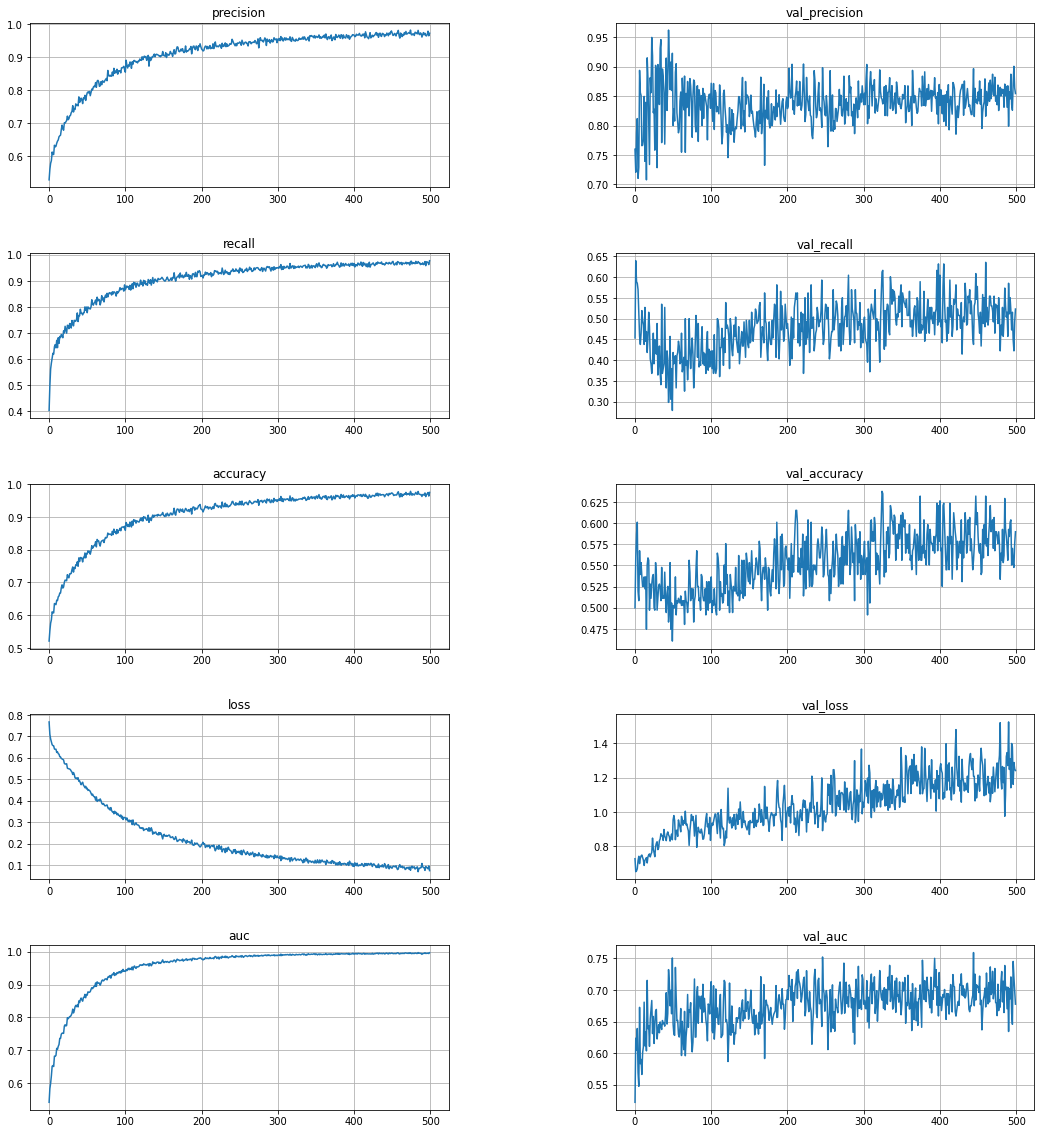

In [18]:
history_dict = history.history
history_dict.keys()

plotted_metrics = ['precision', 'recall', 'accuracy', 'loss', 'auc']

fig = plt.figure(figsize=(18, 4 * len(plotted_metrics)))
fig.subplots_adjust(hspace=0.4, wspace=0.4)


for idx, metric in enumerate(plotted_metrics):
    ax = plt.subplot(len(plotted_metrics), 2, 2*idx+1)
    plt.title(metric)
    plt.plot(history_dict[metric])
    ax.grid()
    
    ax = plt.subplot(len(plotted_metrics), 2, 2*idx+2)
    plt.title('val_{}'.format(metric))
    plt.plot(history_dict['val_{}'.format(metric)])
    ax.grid()

plt.show()

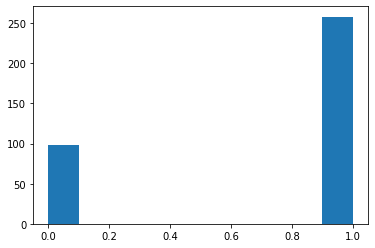

1.0    258
0.0     98
dtype: int64

In [13]:
plt.hist(Y_test)
plt.show()

pd.Series(Y_test).value_counts()

**FEATURE VISUALIZATION** Now, as the model is ready, lets try to explain it a little.

In [14]:
from keras.models import Model

model_viz = Model(inputs=model.inputs, outputs=[model.layers[i].output for i in [0, 4]])
model_viz.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1_input (InputLayer)  (None, 200, 1)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 200, 16)           96        
_________________________________________________________________
batch_normalization_1 (Batch (None, 200, 16)           64        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 200, 16)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 200, 16)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 200, 8)            648       
Total params: 808
Trainable params: 776
Non-trainable params: 32
____________________________________________________________

Sample Label:  1.0
Prediction:  [[0.99939704]]


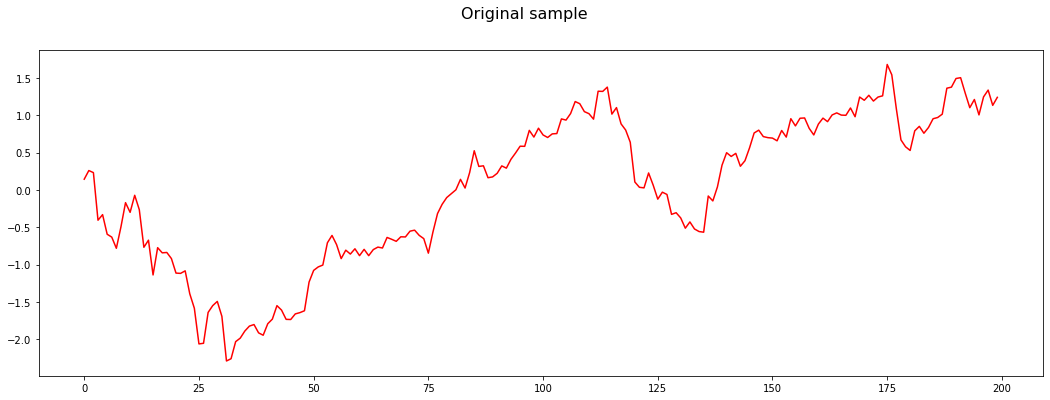

(5, 1, 16)


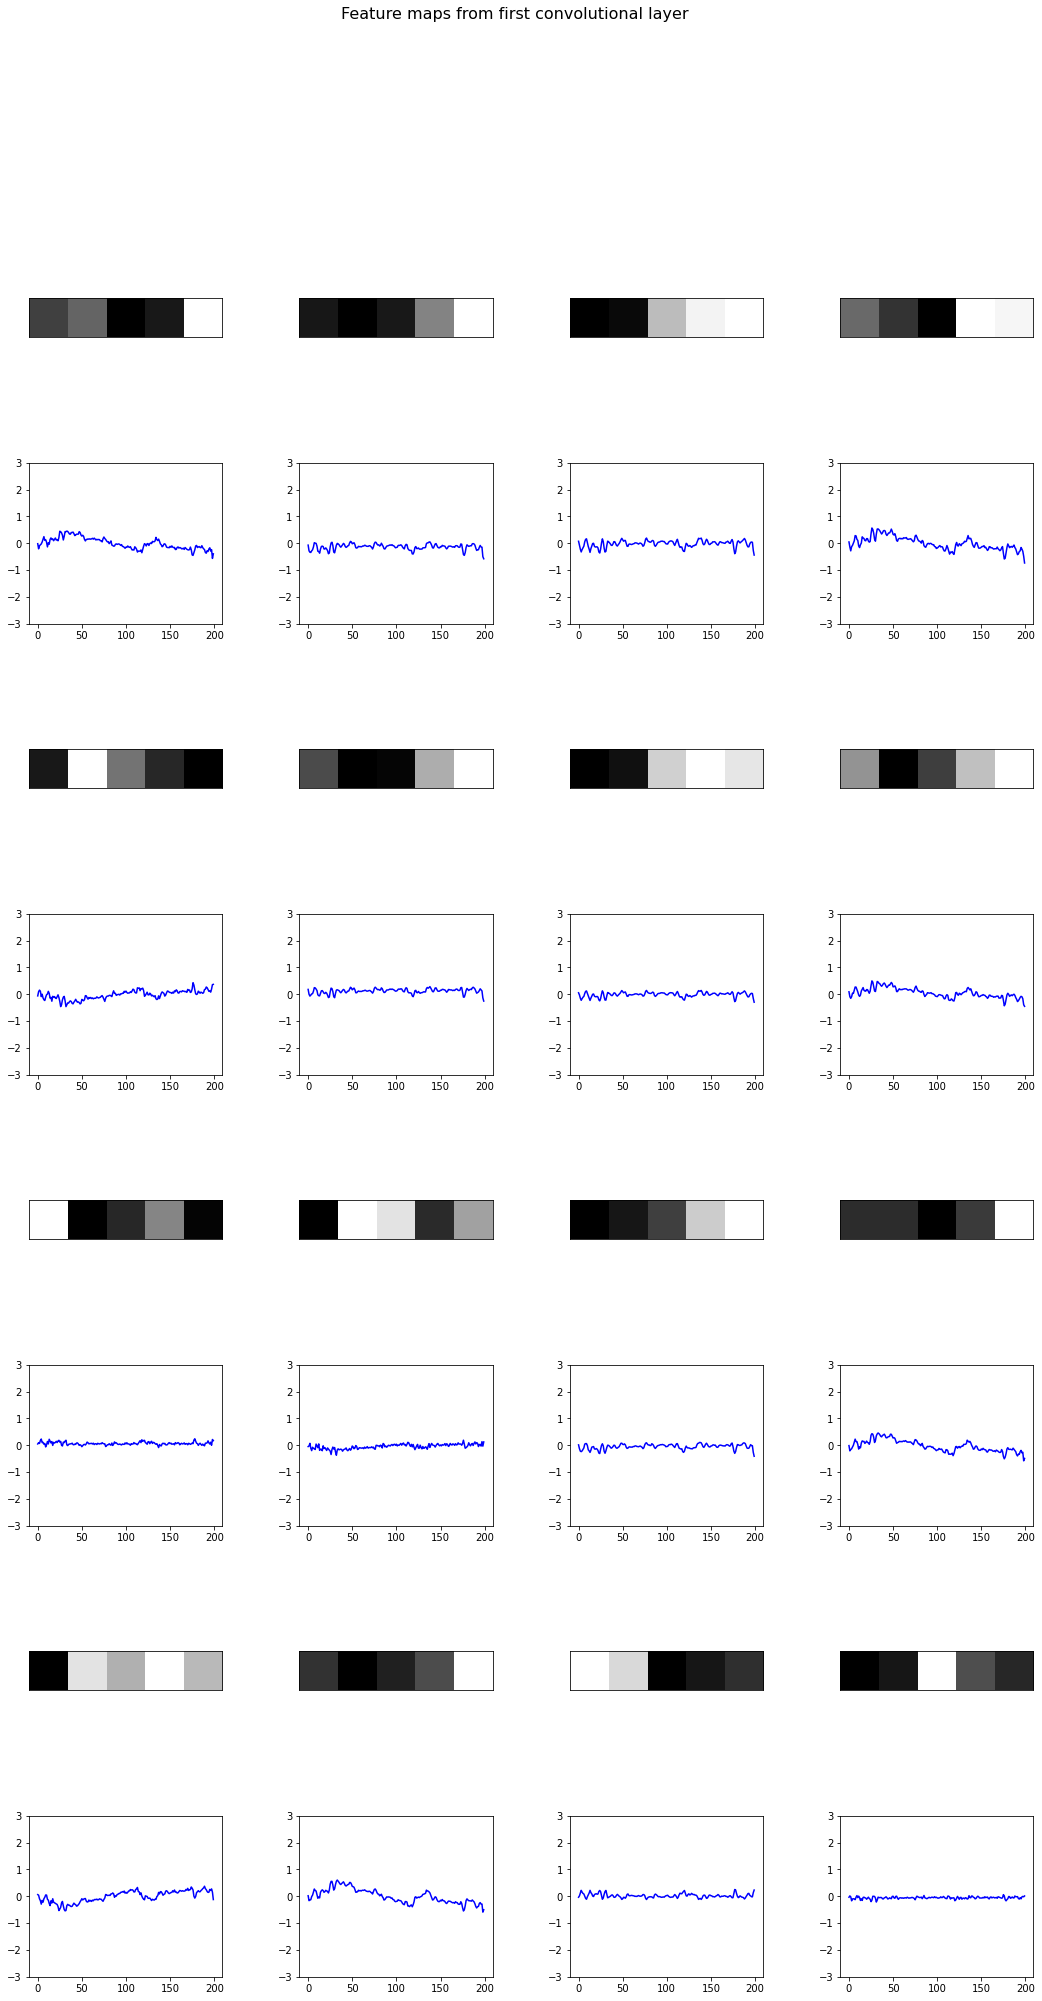

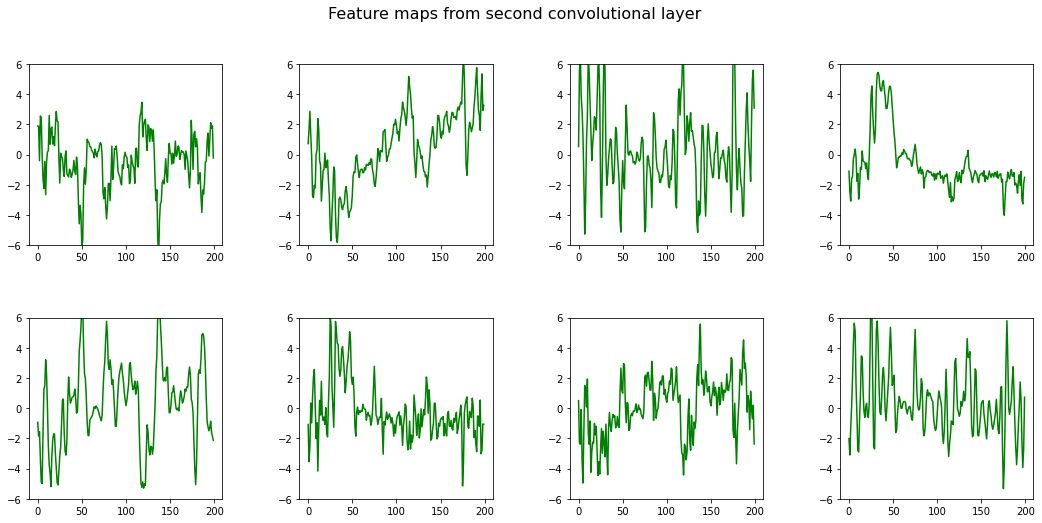

In [15]:
sample_no = 200

sample = X_test[sample_no]
sample_Y = Y_test[sample_no]
print("Sample Label: ", sample_Y)
print("Prediction: ", model.predict(np.array([sample])))

fig = plt.figure(figsize=(18, 6))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
fig.suptitle('Original sample', fontsize=16)
plt.plot(sample, 'r-')
plt.show()

prediction = model_viz.predict(np.array([sample]))

filters1, _ = model.layers[0].get_weights()
filters2, _ = model.layers[4].get_weights()

print(filters1.shape)

square = 4
idx = 1
featuremap_idx = 0
filter_idx = 0

fig = plt.figure(figsize=(18, 32))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
fig.suptitle('Feature maps from first convolutional layer', fontsize=16)
    
for col in range(2*square):
    for row in range(square):
        if col % 2 == 0:
            ax = plt.subplot(2*square, square, idx)
            ax.set_xticks([])
            ax.set_yticks([])
            plt.imshow(np.transpose(filters1[:, :, filter_idx]), cmap='gray')
            filter_idx += 1
        else:
            ax = plt.subplot(2*square, square, idx)
            ax.set_ylim((-3,3))
            plt.plot(prediction[0][:,:,featuremap_idx][0], 'b-')
            featuremap_idx += 1
        idx += 1

plt.show()

idx = 1

fig = plt.figure(figsize=(18, 8))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
fig.suptitle('Feature maps from second convolutional layer', fontsize=16)
    
for _ in range(2):
    for _ in range(4):
        ax = plt.subplot(2, 4, idx)
        ax.set_ylim((-6,6))
        plt.plot(prediction[1][:,:,idx-1][0], 'g-')
        idx += 1

plt.show()